# Population Density of Mexican States and Municipalities

This Notebook downloads Geopandas GeoDataFrames for States (admin1) and Municipalities (admin2) derived from the 2020 Mexican Census: [INEGI](https://www.inegi.org.mx/temas/mg/).

For details how these dataframe were created, see the [mexican-boundaries](https://github.com/sbl-sdsc/mexico-boundaries) GitHub project.

In [1]:
from io import BytesIO
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

## Boundaries of Mexican States

Read boundary polygons for Mexican states from shapefile

In [3]:
admin2_url = 'https://raw.githubusercontent.com/sbl-sdsc/mexico-boundaries/main/data/mexico_admin2.parquet'

In [4]:
resp = urlopen(admin2_url)
admin2 = gpd.read_parquet(BytesIO(resp.read()))

Calculate the area of each state (convert area from m^2 to km^2

In [5]:
admin2.crs

<Projected CRS: PROJCRS["MEXICO_ITRF_2008_LCC",BASEGEOGCRS["MEXICO ...>
Name: MEXICO_ITRF_2008_LCC
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: International Terrestrial Reference Frame 2008
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
admin2['area_sqkm'] = admin2['geometry'].area/ 10**6

Converting the identifying code of municipality that belongs to a certain state

In [7]:
admin2['CVEGEO']=admin2['CVEGEO'].astype('int')

In [8]:
admin2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area_sqkm
0,1001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",1166.359248
1,1002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",543.374266
2,1003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",923.357832
3,1004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",128.383545
4,1005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",499.895092


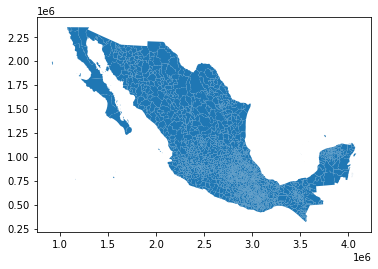

In [9]:
admin2.plot();

## Map of Population by State

Get population from COVID-19 data files

In [10]:
population_admin2 = pd.read_csv('../data/Casos_Diarios_Municipio_Confirmados_20210621.csv', 
                                usecols=['cve_ent', 'poblacion', 'nombre'])

In [11]:
population_admin2.sort_values(by=['cve_ent'], ascending = True, inplace=True)
population_admin2.head()

,cve_ent,poblacion,nombre
429,1001,961977,Aguascalientes
430,1002,50864,Asientos
431,1003,60760,Calvillo
460,1004,16918,Cosio
461,1005,130184,Jesus Maria


Add CVEGEO state-municipality code column

In [12]:
population_admin2.rename(columns = {'cve_ent':'CVEGEO'},inplace=True)

In [13]:
population_admin2.head()

,CVEGEO,poblacion,nombre
429,1001,961977,Aguascalientes
430,1002,50864,Asientos
431,1003,60760,Calvillo
460,1004,16918,Cosio
461,1005,130184,Jesus Maria


Merge the geo dataframe with the population dataframe using the common CVE_ENT column

In [14]:
df_admin2 = admin2.merge(population_admin2, on='CVEGEO')

In [15]:
df_admin2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area_sqkm,poblacion,nombre
0,1001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",1166.359248,961977,Aguascalientes
1,1002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",543.374266,50864,Asientos
2,1003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",923.357832,60760,Calvillo
3,1004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",128.383545,16918,Cosio
4,1005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",499.895092,130184,Jesus Maria


Plot population data

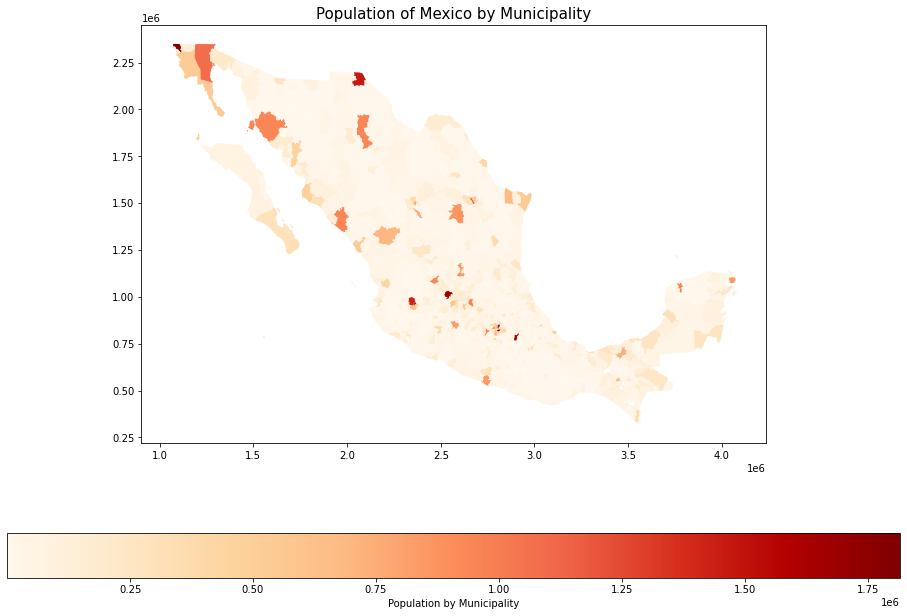

In [16]:
title = 'Population of Mexico by Municipality'
ax1 = df_admin2.plot(column='poblacion', 
                     cmap='OrRd',
                     legend=True, 
                     legend_kwds={'label': 'Population by Municipality', 
                                  'orientation': 'horizontal'},
                     figsize=(16, 11));
ax1.set_title(title, fontsize=15);

## Map of Population Density by State

In [17]:
df_admin2['population/sqkm']=df_admin2['poblacion']/df_admin2['area_sqkm']

In [18]:
df_admin2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area_sqkm,poblacion,nombre,population/sqkm
0,1001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",1166.359248,961977,Aguascalientes,824.769043
1,1002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",543.374266,50864,Asientos,93.607672
2,1003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",923.357832,60760,Calvillo,65.803308
3,1004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",128.383545,16918,Cosio,131.777013
4,1005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",499.895092,130184,Jesus Maria,260.422641


In [19]:
df_admin2.nlargest(10, 'population/sqkm')

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area_sqkm,poblacion,nombre,population/sqkm
727,15058,15,058,Nezahualcóyotl,"POLYGON ((2815065.814 828483.282, 2815102.619 ...",62.899631,1135786,Nezahualcoyotl,18057.117020
269,9006,09,006,Iztacalco,"POLYGON ((2808145.908 826363.205, 2808144.575 ...",22.962785,393821,Iztacalco,17150.402470
278,9015,09,015,Cuauhtémoc,"POLYGON ((2800483.029 832381.312, 2800517.052 ...",32.335245,548606,Cuauhtemoc,16966.192866
277,9014,09,014,Benito Juárez,"POLYGON ((2798716.061 825872.886, 2798801.484 ...",26.548923,433708,Benito Juarez,16336.180396
270,9007,09,007,Iztapalapa,"POLYGON ((2812453.035 823708.051, 2812495.143 ...",112.528064,1815551,Iztapalapa,16134.206309
268,9005,09,005,Gustavo A. Madero,"POLYGON ((2802175.660 843326.718, 2801806.564 ...",87.378306,1176967,Gustavo A. Madero,13469.785014
686,15031,15,031,Chimalhuacán,"POLYGON ((2822018.300 828822.113, 2822016.097 ...",54.504078,720207,Chimalhuacan,13213.818654
280,9017,09,017,Venustiano Carranza,"POLYGON ((2802603.341 831349.500, 2802657.676 ...",33.666050,433231,Venustiano Carranza,12868.483394
265,9002,09,002,Azcapotzalco,"POLYGON ((2794859.977 837218.408, 2794861.690 ...",33.323092,408441,Azcapotzalco,12256.996012
266,9003,09,003,Coyoacán,"POLYGON ((2800218.995 820661.624, 2800250.439 ...",53.622314,621952,Coyoacan,11598.753401


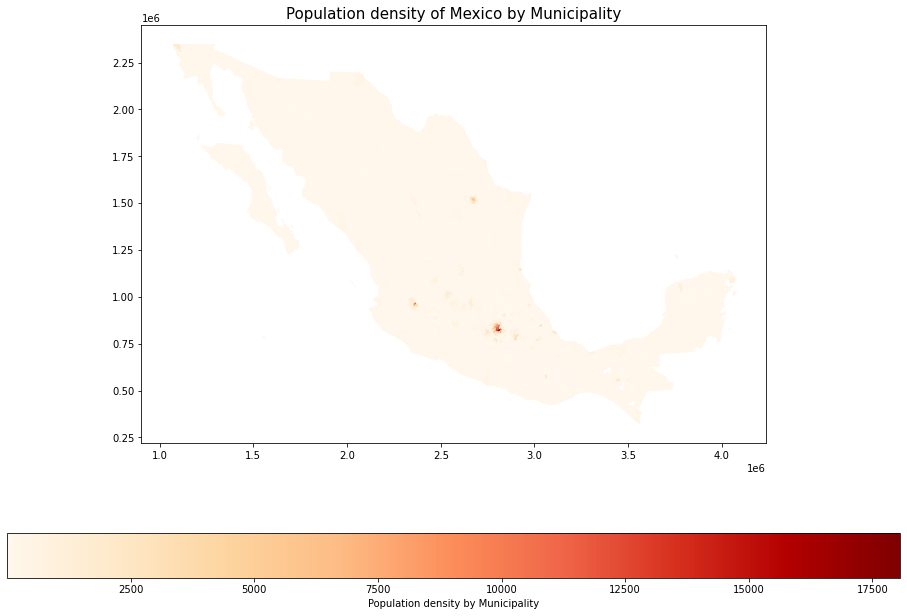

In [20]:
title = 'Population density of Mexico by Municipality'
ax1 = df_admin2.plot(column='population/sqkm', 
                     cmap='OrRd',
                     legend=True, 
                     legend_kwds={'label': 'Population density by Municipality', 
                                  'orientation': 'horizontal'},
                     figsize=(16, 11));
ax1.set_title(title, fontsize=15);

## Map of Cases Rate by State

In [24]:
week3_admin2 = pd.read_csv('../data/week3analyzesMunicipalities.csv')

In [25]:
week3_admin2.head()

,cve_ent,municipalitie,cases_rate,cases_rate_last_60_days,deaths_rate,deaths_rate_last_60_days,population,pct_disability,pct_limitation,pct_mental_problem,pct_no_problems,average_years_finish,pct_no_med_afilation,pct_med_afilation,average_household_size,pct_household_tics,pct_household_no_tics,pct_pop_0_14_years_old,pct_pop_15_64_years_old,pct_pop_65_more_years_old
0,1001,Aguascalientes,2294.857361,70.687761,222.770399,7.484586,961977,4.940347,12.131787,1.449619,80.812119,10.84,18.004485,80.497039,3.54,99.725989,0.274011,25.009226,66.481007,7.062643
1,1002,Asientos,912.236552,29.490406,70.776974,1.966027,50864,5.673954,8.947389,1.360491,85.929144,8.54,14.922145,86.351840,4.10,98.588742,1.411258,31.979396,62.753617,6.548836
2,1003,Calvillo,1616.194865,8.229098,42.791310,0.000000,60760,6.728111,11.125741,1.960171,77.080316,8.05,19.473338,76.316656,3.74,99.112312,0.887688,27.518104,59.009217,9.284068
3,1004,Cosio,768.412342,29.554321,70.930370,0.000000,16918,4.758246,11.425700,1.217638,83.733302,9.08,13.872798,86.600071,4.32,98.729997,1.270003,30.636009,63.240336,6.608346
4,1005,Jesus Maria,598.383826,16.131015,47.624900,0.768144,130184,3.868371,9.143981,1.261292,86.048209,10.22,20.969551,78.679408,3.91,99.554405,0.445595,29.422202,65.253026,5.022123


In [26]:
week3_admin2.rename(columns={'cve_ent':'CVEGEO'},inplace=True)

In [27]:
df_admin2 = admin2.merge(week3_admin2, on='CVEGEO')

In [28]:
df_admin2.head()

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,area_sqkm,municipalitie,cases_rate,cases_rate_last_60_days,deaths_rate,deaths_rate_last_60_days,population,pct_disability,pct_limitation,pct_mental_problem,pct_no_problems,average_years_finish,pct_no_med_afilation,pct_med_afilation,average_household_size,pct_household_tics,pct_household_no_tics,pct_pop_0_14_years_old,pct_pop_15_64_years_old,pct_pop_65_more_years_old
0,1001,01,001,Aguascalientes,"POLYGON ((2489072.503 1115771.584, 2489352.774...",1166.359248,Aguascalientes,2294.857361,70.687761,222.770399,7.484586,961977,4.940347,12.131787,1.449619,80.812119,10.84,18.004485,80.497039,3.54,99.725989,0.274011,25.009226,66.481007,7.062643
1,1002,01,002,Asientos,"POLYGON ((2494680.261 1141224.505, 2494749.948...",543.374266,Asientos,912.236552,29.490406,70.776974,1.966027,50864,5.673954,8.947389,1.360491,85.929144,8.54,14.922145,86.351840,4.10,98.588742,1.411258,31.979396,62.753617,6.548836
2,1003,01,003,Calvillo,"POLYGON ((2429607.454 1120262.254, 2429071.902...",923.357832,Calvillo,1616.194865,8.229098,42.791310,0.000000,60760,6.728111,11.125741,1.960171,77.080316,8.05,19.473338,76.316656,3.74,99.112312,0.887688,27.518104,59.009217,9.284068
3,1004,01,004,Cosío,"POLYGON ((2470517.824 1155028.588, 2470552.248...",128.383545,Cosio,768.412342,29.554321,70.930370,0.000000,16918,4.758246,11.425700,1.217638,83.733302,9.08,13.872798,86.600071,4.32,98.729997,1.270003,30.636009,63.240336,6.608346
4,1005,01,005,Jesús María,"POLYGON ((2465526.729 1114740.466, 2465752.546...",499.895092,Jesus Maria,598.383826,16.131015,47.624900,0.768144,130184,3.868371,9.143981,1.261292,86.048209,10.22,20.969551,78.679408,3.91,99.554405,0.445595,29.422202,65.253026,5.022123


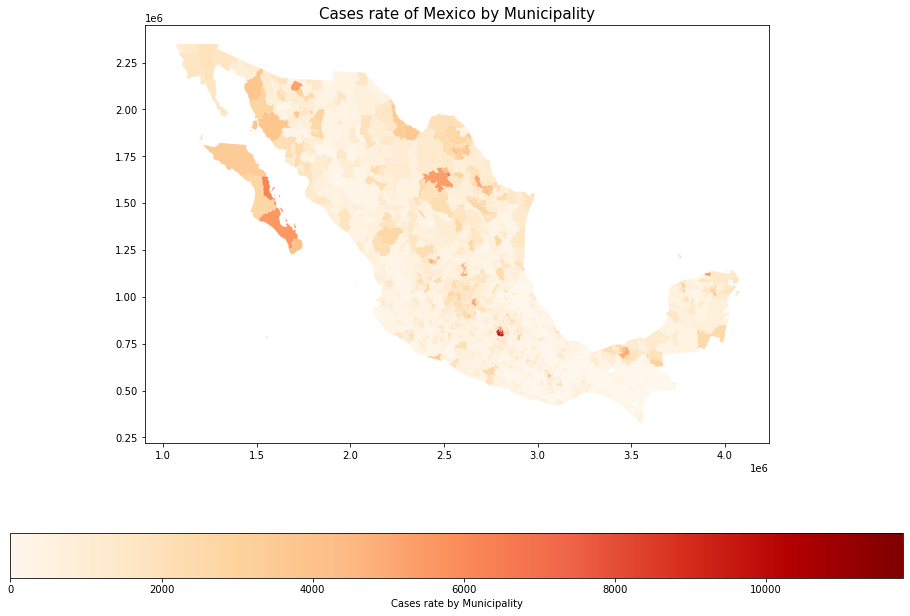

In [29]:
title = 'Cases rate of Mexico by Municipality'
ax1 = df_admin2.plot(column='cases_rate', 
                     cmap='OrRd',
                     legend=True, 
                     legend_kwds={'label': 'Cases rate by Municipality', 
                                  'orientation': 'horizontal'},
                     figsize=(16, 11));
ax1.set_title(title, fontsize=15);

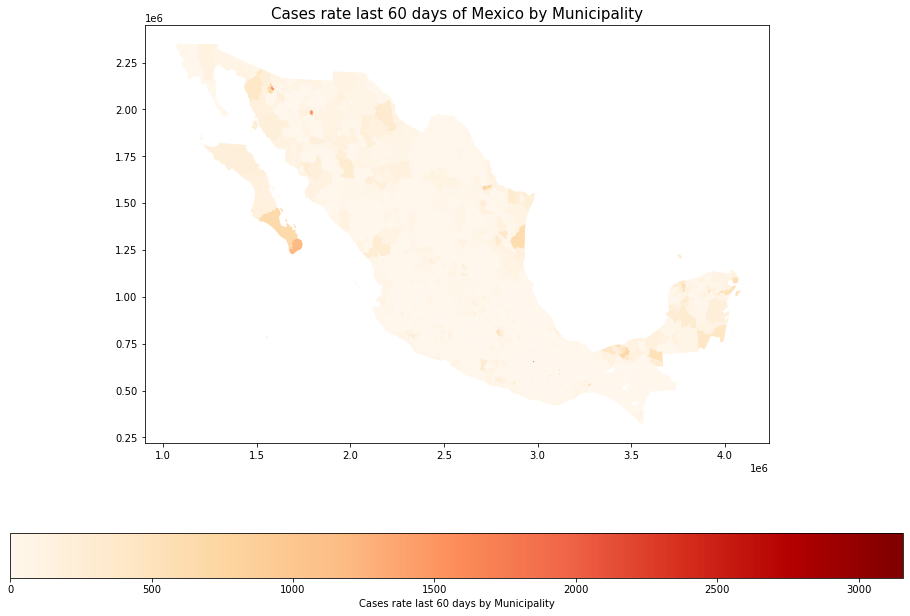

In [30]:
title = 'Cases rate last 60 days of Mexico by Municipality'
ax1 = df_admin2.plot(column='cases_rate_last_60_days', 
                     cmap='OrRd',
                     legend=True, 
                     legend_kwds={'label': 'Cases rate last 60 days by Municipality', 
                                  'orientation': 'horizontal'},
                     figsize=(16, 11));
ax1.set_title(title, fontsize=15);